# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!unzip -q "/content/drive/MyDrive/isic-2019.zip" #https://www.kaggle.com/datasets/andrewmvd/isic-2019

Mounted at /content/drive
replace ISIC_2019_Training_GroundTruth.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os
#os.system('pip install .')
os.system('pip install git+https://github.com/hamish-haggerty/base_rbt.git')
os.system('pip install git+https://github.com/hamish-haggerty/cancer-proj.git')
!pip install -qU git+https://github.com/hamish-haggerty/cancer-proj.git #sometimes os doesn't work so use this if imports below fail

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
from fastai.vision.all import *
from base_rbt.all import *
#TODO: wrap this in an .all
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *
from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module
from statistics import mean,stdev

import fastai
test_eq(fastai.__version__,'2.7.13')

import torch
test_eq(torch.__version__,'2.1.0+cu121')


#Get data paths:

In [ ]:
save_directory = '/content/drive/My Drive/cancer_colab' #directory for saving models etc
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [ ]:
directory = "/content/ISIC_2019_Training_Input/"
data = pd.read_csv("/content/ISIC_2019_Training_GroundTruth.csv").drop("UNK", axis=1)
data = data[~data["image"].str.contains("downsampled")]
labels = pd.read_csv("/content/ISIC_2019_Training_GroundTruth.csv")

# Build training, tuning, validation test sets:
    - Training is unlabelled
    - Tuning is for supervised fine tuning
    - Validation is a held out (proxy) test set
    - Test set is for getting results

In [ ]:
# xiaochen:reconstruct some functions in cancer_downloading.py as they are not bug-free

def extract_id(string):
    regex = r'ISIC_\d+'
    match = re.search(regex, string)
    if match:
        return match.group(0)
    else:
        return None

def get_class_from_id(string, data):
    "Given the identifier e.g. ISIC_0000000.jpg return the class label"

    row=data.loc[data['image'] == string]
    lst = [colname for colname in row.columns if row[colname].values==1]
    test_eq(len(lst),1)

    return lst[0]

def get_label_func_dict(_fnames, data):
    label_func_dict={}
    for name in _fnames:
        label_func_dict[name] = get_class_from_id(extract_id(process_path(name)), data)

    return label_func_dict

In [ ]:
_fnames = get_image_files(directory)
_fnames = [name for name in _fnames if 'downsampled' not in name.as_posix()] #otherwise load like this
test_eq(len(_fnames),len(data))

label_func_dict = get_label_func_dict(_fnames,data)
print(label_func_dict)
def label_func(name):
    return label_func_dict[name]
_labels = [label_func(i) for i in _fnames]

{Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0031043.jpg'): 'SCC', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0028498.jpg'): 'NV', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0027230.jpg'): 'NV', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0070208.jpg'): 'NV', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0033368.jpg'): 'MEL', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0054002.jpg'): 'BKL', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0025415.jpg'): 'NV', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0032532.jpg'): 'MEL', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0026139.jpg'): 'BKL', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0062809.jpg'): 'MEL', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065890.jpg')

In [ ]:
print(len(_labels))

In [ ]:
#tests / sanity checks:
#test_eq(process_path(_fnames[0]),'ISIC_0071718.jpg')
#test_eq(process_path(_fnames[10]),'ISIC_0071719.jpg')

_fnames_dict = get_fnames(_fnames,_labels,label_func)
fnames_train,fnames_valid,fnames_test = _fnames_dict['fnames_train'],_fnames_dict['fnames_valid'],_fnames_dict['fnames_test']
labels_train,labels_valid,labels_test = _fnames_dict['labels_train'],_fnames_dict['labels_valid'],_fnames_dict['labels_test']

print(f'Training (tuning) set has: \n{Counter(labels_train)}\n')

print(f'Validation set has: \n{Counter(labels_valid)}\n')

print(f'Test set has: \n{Counter(labels_test)}\n')

#A few tests: Make sure fnames_train and fnames_test the same every time

# xiaochen: cannot pass this check. But I believe that is does not matter as there are no overlap between these three sets, and these sets follow
# the same distribution with the original ones.

# test_eq(process_path(fnames_train[44]),'ISIC_0071754.jpg')
# test_eq(process_path(fnames_test[10]),'ISIC_0000011.jpg')

#Make sure training and valid are disjoint
for path in fnames_valid: assert path not in fnames_train #check that valid set is disjoint from training (tuning) set

#Make sure test and valid+train are disjoint
for path in fnames_test: assert path not in fnames_train+fnames_valid #check that test set is disticnt from training and validation set

23257
Training (tuning) set has: 
Counter({'NV': 500, 'MEL': 500, 'BCC': 500, 'BKL': 490, 'AK': 180, 'SCC': 146, 'VASC': 60, 'DF': 54})

Validation set has: 
Counter({'NV': 649, 'MEL': 222, 'BCC': 182, 'BKL': 121, 'AK': 42, 'SCC': 35, 'VASC': 19, 'DF': 10})

Test set has: 
Counter({'NV': 10410, 'MEL': 3426, 'BCC': 2641, 'BKL': 1629, 'AK': 645, 'SCC': 447, 'DF': 175, 'VASC': 174})



# Setup dataloaders

In [ ]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

size=256
item_tfms = [Resize(size)]

item_tfms_train = [Resize(128)]

dls_tune  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=64,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_valid  = ImageDataLoaders.from_path_func(directory, fnames_valid, label_func,
                                bs=256,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )

#This is for training BT (so viewed as unlabelled)
dls_train  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=128,
                                item_tfms=item_tfms_train,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_test =  ImageDataLoaders.from_path_func(directory, fnames_test, label_func,
                                bs=64,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda'),
                                shuffle=False
                                )

classes_to_int={v:i for i,v in enumerate(dls_tune.vocab)}
int_to_classes = {i: v for i, v in enumerate(dls_tune.vocab)}
vocab=dls_tune.vocab

# Aug pipelines

In [ ]:
aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines'] #Heavy augmentation. Use to train BT
aug_pipelines_tune = aug_dict['aug_pipelines_tune'] #Used for fine tuning
aug_pipelines_test = aug_dict['aug_pipelines_test'] #Test time augmentation (generally same as above)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


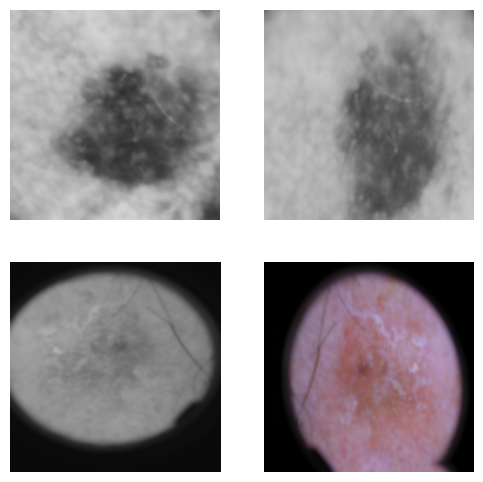

In [ ]:
show_bt_batch(dls_train,n_in=3,n=2,aug=aug_pipelines)

# Fine tune supervised model, get test set performance:

Description: Sup initial weights, 40 epochs

The general tune model path is: /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain (if None mean no saving)
The dict_path is: supervised_pretrain
tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0
Froze head


epoch,train_loss,valid_loss,time
0,1.710510,None,01:00


/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0
Unfroze head


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0
We are saving after true epoch 2 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0
Learning rate finder yielded lr_max: 0.00013182566908653826


epoch,train_loss,valid_loss,time
0,1.377813,None,00:56


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.00      0.00      0.00       645
         BCC       0.44      0.83      0.58      2641
         BKL       0.35      0.35      0.35      1629
          DF       0.00      0.00      0.00       175
         MEL       0.48      0.57      0.52      3426
          NV       0.87      0.74      0.80     10410
         SCC       0.00      0.00      0.00       447
        VASC       0.00      0.00      0.00       174

    accuracy                           0.63     19547
   macro avg       0.27      0.31      0.28     19547
weighted avg       0.63      0.63      0.62     19547

auc_dict is: {'AK': 0.8838719334896679, 'BCC': 0.9171741799870482, 'BKL': 0.8114739467587525, 'DF': 0.8084656794784814, 'MEL': 0.821056195968079, 'NV': 0.8912247202552416, 'SCC': 0.8614210501657354, 'VASC': 0.9527090968530085}


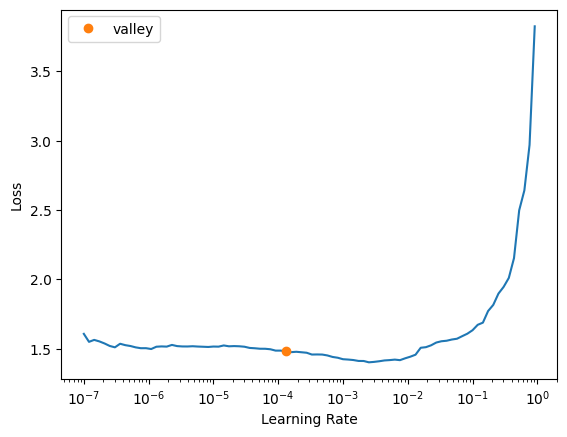

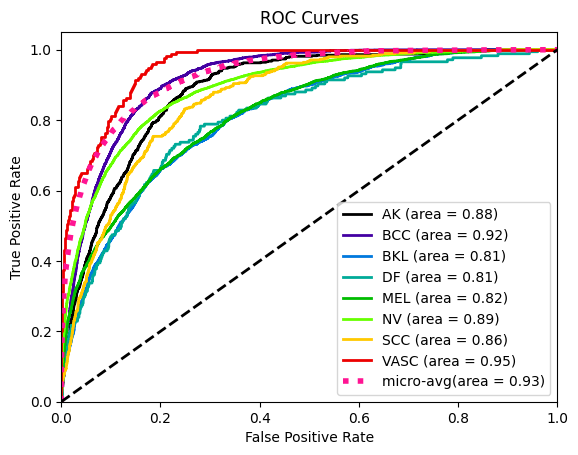

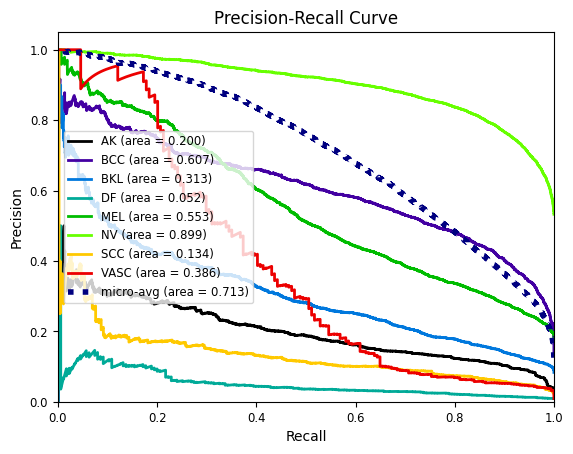

auc_dict is: {'AK': 0.19998628777790084, 'BCC': 0.6071984543458564, 'BKL': 0.3132606251320375, 'DF': 0.052274106372726115, 'MEL': 0.5533889172374719, 'NV': 0.8994297622712651, 'SCC': 0.13379014559228228, 'VASC': 0.385692340933383}
0.6344196200370789
tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1
Froze head


epoch,train_loss,valid_loss,time
0,1.677910,None,01:03


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1
Unfroze head


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1
We are saving after true epoch 2 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1
Learning rate finder yielded lr_max: 0.00013182566908653826


epoch,train_loss,valid_loss,time
0,1.358577,None,00:57


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.42      0.02      0.04       645
         BCC       0.48      0.79      0.60      2641
         BKL       0.35      0.38      0.37      1629
          DF       0.00      0.00      0.00       175
         MEL       0.46      0.59      0.51      3426
          NV       0.85      0.75      0.80     10410
         SCC       0.00      0.00      0.00       447
        VASC       0.00      0.00      0.00       174

    accuracy                           0.64     19547
   macro avg       0.32      0.32      0.29     19547
weighted avg       0.64      0.64      0.63     19547

auc_dict is: {'AK': 0.881528102108058, 'BCC': 0.9222927783906852, 'BKL': 0.8222453581080882, 'DF': 0.8111601427686499, 'MEL': 0.8226554468608729, 'NV': 0.8971340467136135, 'SCC': 0.8798939995549152, 'VASC': 0.9320540911601701}


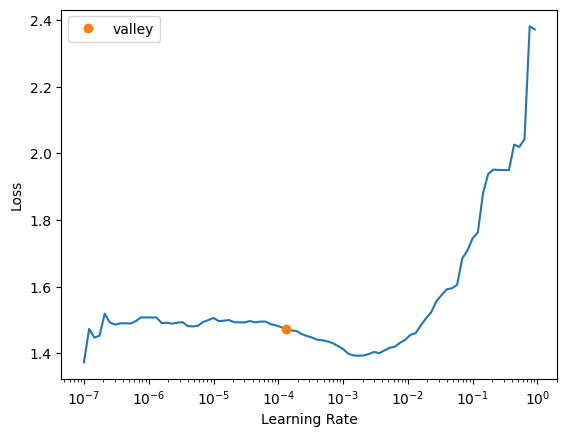

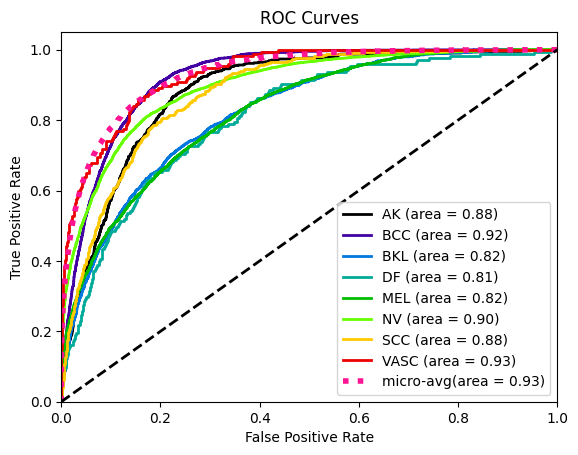

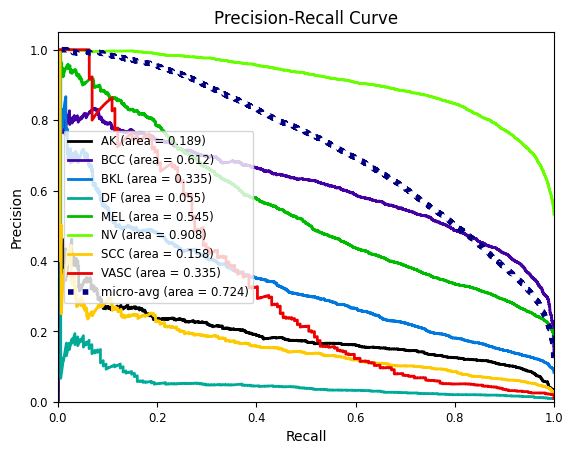

auc_dict is: {'AK': 0.18947348527386454, 'BCC': 0.6120287246034166, 'BKL': 0.3354790328255261, 'DF': 0.054663644170871065, 'MEL': 0.544519870520874, 'NV': 0.9080116026275029, 'SCC': 0.15802059498714618, 'VASC': 0.3351094625649754}
0.6387680768966675
tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2
Froze head


epoch,train_loss,valid_loss,time
0,1.676103,None,01:01


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2
Unfroze head


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2
We are saving after true epoch 2 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2
Learning rate finder yielded lr_max: 0.00015848931798245758


epoch,train_loss,valid_loss,time
0,1.346439,None,00:57


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.40      0.07      0.12       645
         BCC       0.46      0.87      0.60      2641
         BKL       0.35      0.40      0.38      1629
          DF       0.00      0.00      0.00       175
         MEL       0.50      0.50      0.50      3426
          NV       0.86      0.76      0.81     10410
         SCC       0.00      0.00      0.00       447
        VASC       0.00      0.00      0.00       174

    accuracy                           0.65     19547
   macro avg       0.32      0.33      0.30     19547
weighted avg       0.65      0.65      0.63     19547

auc_dict is: {'AK': 0.8922219788890722, 'BCC': 0.9285524054807721, 'BKL': 0.8295045891826561, 'DF': 0.8126316332851538, 'MEL': 0.8113558663714822, 'NV': 0.8968591565450964, 'SCC': 0.857080419785188, 'VASC': 0.9511027018881}


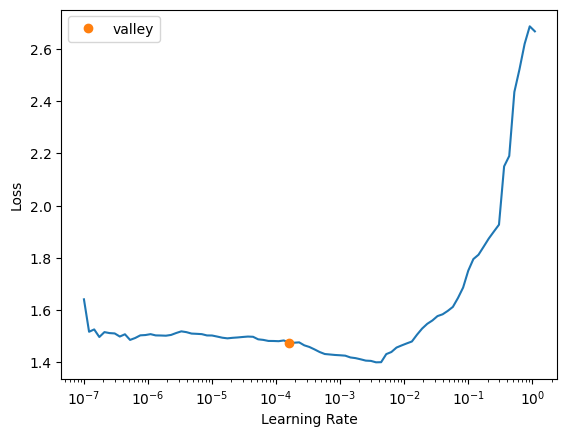

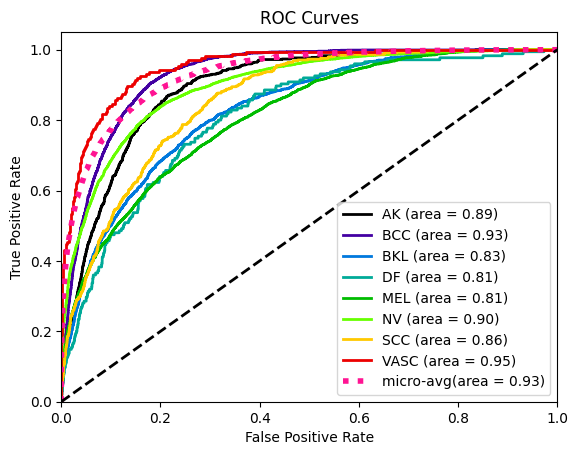

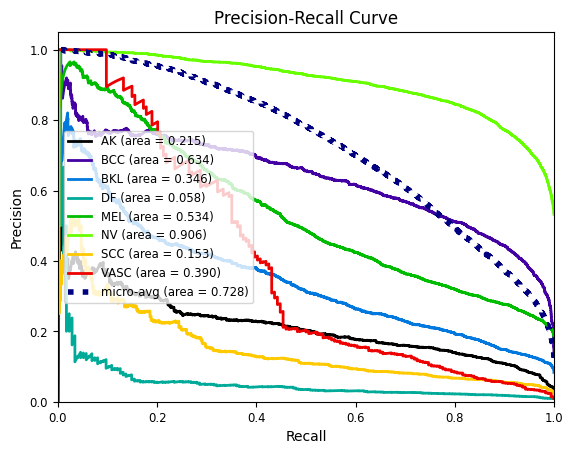

auc_dict is: {'AK': 0.21461326002224826, 'BCC': 0.6339494204925671, 'BKL': 0.34554509957956525, 'DF': 0.057981598782528954, 'MEL': 0.5335301496912206, 'NV': 0.9061908979444528, 'SCC': 0.1530997997031748, 'VASC': 0.3902976248303413}
0.6456745266914368
We are saving the dictionary at supervised_pretrain


In [ ]:
#Hyperparams: description, type of intial weights, number of epochs, number of runs

#In this block we set the hps for the run. Then we call `main_tune` with these values
#########
description = 'Sup initial weights, 40 epochs'
initial_weights='supervised_pretrain'
epochs=1
runs=range(3) #we have already saved results for runs 0,1,2


tune_model_path = save_directory + f'/initial_weights={initial_weights}'
dict_path = f'{initial_weights}' #file to load dictionary metadata

#_results=load_dict_from_gdrive(save_directory,'supervised_pretrain')
_results=None
#########

#fine tune
sup_results = main_tune(initial_weights=initial_weights,epochs=epochs,device=device,dls_tune=dls_tune,dls_test=dls_test,
                        aug_pipelines_tune=aug_pipelines_tune,aug_pipelines_test=aug_pipelines_tune,int_to_classes=int_to_classes,
                        tune_model_path=tune_model_path, dict_path = dict_path,save_directory=save_directory,description=description,
                        results=_results,runs=runs,
                        )

# As above but for BT initial weights:

Description: BT initial weights, 40 epochs

The general tune model path is: /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain (if None mean no saving)
The dict_path is: bt_pretrain


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0
Froze head


epoch,train_loss,valid_loss,time
0,1.748735,None,00:59


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0
Unfroze head


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0
We are saving after true epoch 2 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0
Learning rate finder yielded lr_max: 0.0006918309954926372


epoch,train_loss,valid_loss,time
0,1.462257,None,00:59


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.29      0.01      0.01       645
         BCC       0.49      0.80      0.61      2641
         BKL       0.34      0.33      0.33      1629
          DF       0.00      0.00      0.00       175
         MEL       0.42      0.61      0.50      3426
          NV       0.86      0.71      0.78     10410
         SCC       0.00      0.00      0.00       447
        VASC       0.00      0.00      0.00       174

    accuracy                           0.62     19547
   macro avg       0.30      0.31      0.28     19547
weighted avg       0.63      0.62      0.61     19547

auc_dict is: {'AK': 0.8958834592787441, 'BCC': 0.9250935177440368, 'BKL': 0.8082824415790617, 'DF': 0.7885288044600454, 'MEL': 0.8072727816234153, 'NV': 0.8910928026223092, 'SCC': 0.8684564929664897, 'VASC': 0.916746615594283}


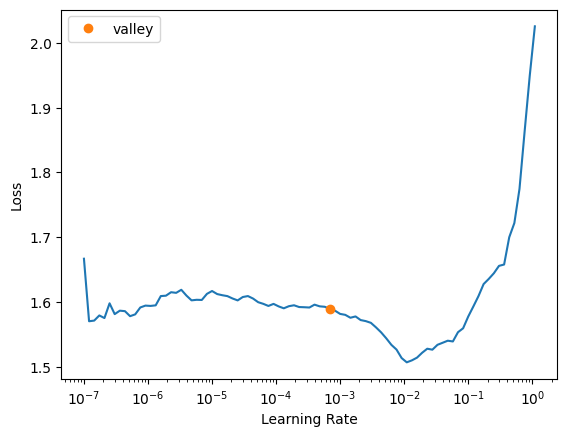

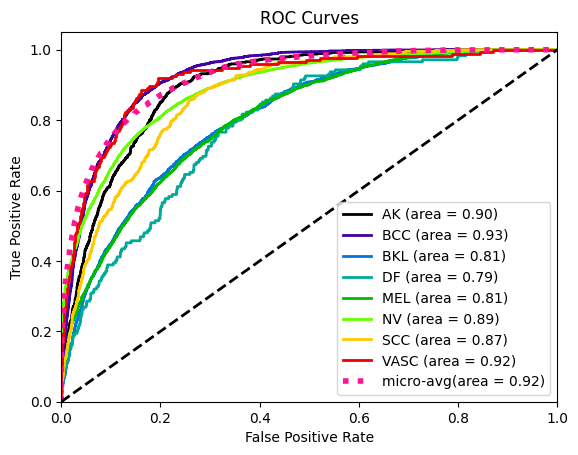

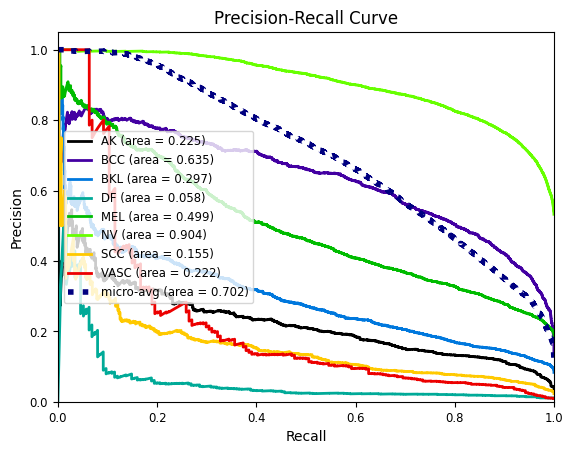

auc_dict is: {'AK': 0.22495193834790686, 'BCC': 0.6346220349321599, 'BKL': 0.2973650810275963, 'DF': 0.05837887364570723, 'MEL': 0.49915737442072067, 'NV': 0.9042624046094567, 'SCC': 0.15530620340359305, 'VASC': 0.22160619686435995}
0.6223973035812378


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1
Froze head


epoch,train_loss,valid_loss,time
0,1.752992,None,00:59


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1
Unfroze head


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1
We are saving after true epoch 2 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1
Learning rate finder yielded lr_max: 0.0008317637839354575


epoch,train_loss,valid_loss,time
0,1.424484,None,01:01


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.38      0.00      0.01       645
         BCC       0.52      0.77      0.62      2641
         BKL       0.30      0.44      0.35      1629
          DF       0.00      0.00      0.00       175
         MEL       0.50      0.49      0.49      3426
          NV       0.83      0.79      0.81     10410
         SCC       0.00      0.00      0.00       447
        VASC       0.00      0.00      0.00       174

    accuracy                           0.64     19547
   macro avg       0.31      0.31      0.29     19547
weighted avg       0.64      0.64      0.63     19547

auc_dict is: {'AK': 0.8975314125325321, 'BCC': 0.9220565007581626, 'BKL': 0.8138961229216158, 'DF': 0.7847491224447656, 'MEL': 0.8109082698548733, 'NV': 0.8909992906568883, 'SCC': 0.8638192955948325, 'VASC': 0.9273568320882661}


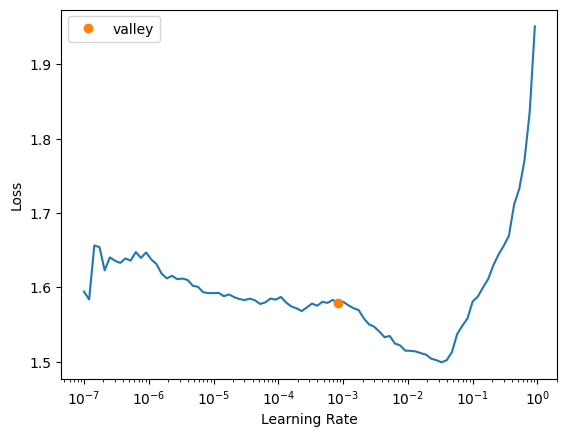

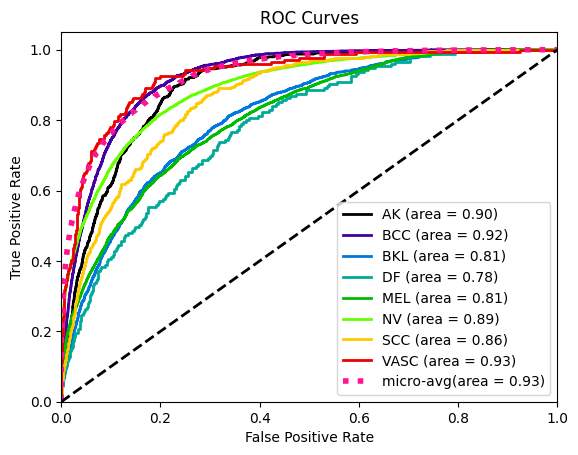

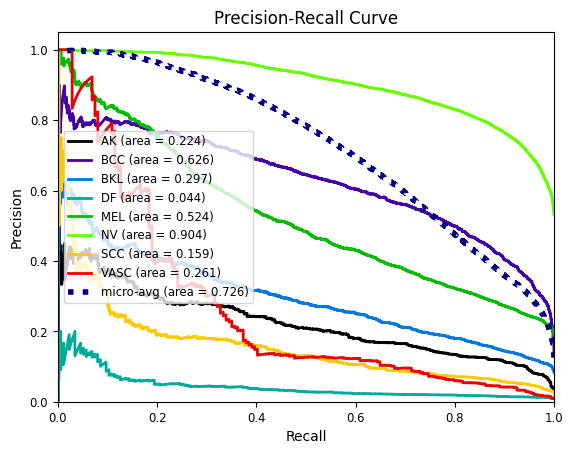

auc_dict is: {'AK': 0.2242950466785547, 'BCC': 0.6257238280306925, 'BKL': 0.29745636038715867, 'DF': 0.04373621804433661, 'MEL': 0.5239803303837558, 'NV': 0.9037422456028086, 'SCC': 0.15912431908340705, 'VASC': 0.2611464619865006}
0.6448559761047363


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tune_model_path for this run is: /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2
Froze head


epoch,train_loss,valid_loss,time
0,1.749681,None,00:55


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2
Unfroze head


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2
We are saving after true epoch 2 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2
Learning rate finder yielded lr_max: 0.0010000000474974513


epoch,train_loss,valid_loss,time
0,1.426269,None,00:58


We are saving after true epoch 1 at path /content/drive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.50      0.01      0.02       645
         BCC       0.51      0.76      0.61      2641
         BKL       0.29      0.46      0.36      1629
          DF       0.00      0.00      0.00       175
         MEL       0.46      0.55      0.50      3426
          NV       0.86      0.74      0.79     10410
         SCC       0.00      0.00      0.00       447
        VASC       0.00      0.00      0.00       174

    accuracy                           0.63     19547
   macro avg       0.33      0.32      0.29     19547
weighted avg       0.65      0.63      0.62     19547

auc_dict is: {'AK': 0.8931675332334299, 'BCC': 0.9244163542689418, 'BKL': 0.8133938861100473, 'DF': 0.8049412996666765, 'MEL': 0.8092858614868664, 'NV': 0.8947528059634865, 'SCC': 0.8727619850779484, 'VASC': 0.9194975113485945}


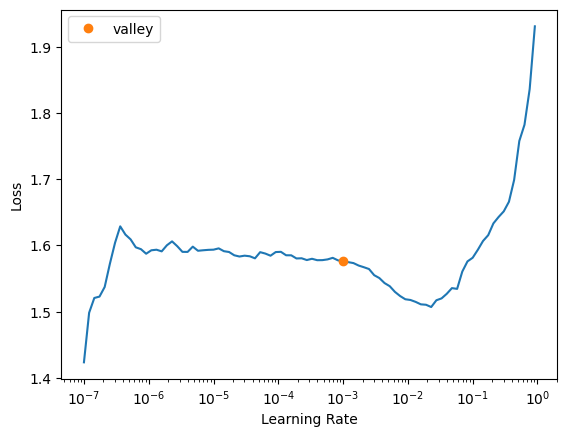

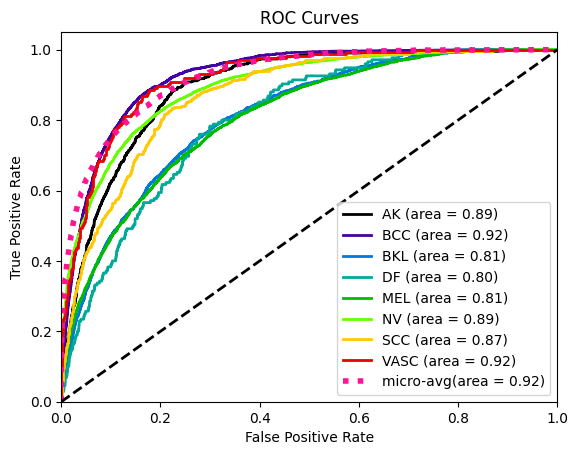

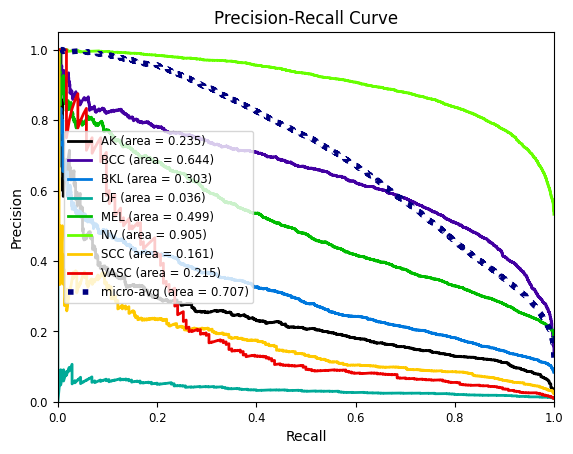

auc_dict is: {'AK': 0.2351546323088347, 'BCC': 0.644080144002334, 'BKL': 0.30283373473049857, 'DF': 0.03596915944481621, 'MEL': 0.49890884833869376, 'NV': 0.9052857792274298, 'SCC': 0.16125863445235125, 'VASC': 0.21542471324546814}
0.6321174502372742
We are saving the dictionary at bt_pretrain


In [ ]:
#In this block we set the hps for the run. Then we call `main_tune` with these values
#########
description = 'BT initial weights, 40 epochs'
initial_weights='bt_pretrain'
epochs=1

runs=range(3) #we have already saved results for runs 0,1,2

tune_model_path = save_directory + f'/initial_weights={initial_weights}'
dict_path = f'{initial_weights}' #file to load dictionary metadata

#_results=load_dict_from_gdrive(save_directory,'supervised_pretrain')
_results=None
#########

#fine tune
bt_results = main_tune(initial_weights=initial_weights,epochs=epochs,device=device,dls_tune=dls_tune,dls_test=dls_test,
                        aug_pipelines_tune=aug_pipelines_tune,aug_pipelines_test=aug_pipelines_tune,int_to_classes=int_to_classes,
                        tune_model_path=tune_model_path, dict_path = dict_path,save_directory=save_directory,description=description,
                        results=_results,runs=runs,
                        )

Verify loading and check results:

In [ ]:
sup_results = load_dict_from_gdrive(save_directory,'supervised_pretrain')

In [ ]:
lst=[sup_results[i]['acc'] for i in range(3)]
print(sup_results.keys())
print(mean(lst))
print(stdev(lst))

dict_keys([0, 1, 2])
0.6396207412083944
0.005675694518818557


In [ ]:
bt_results = load_dict_from_gdrive(save_directory,'bt_pretrain')
print(bt_results.keys())
lst=[bt_results[i]['acc'] for i in range(3)]
print(mean(lst))
print(stdev(lst))

dict_keys([0, 1, 2])
0.6331235766410828
0.011263090634225032


# Mean classification report for supervised weights:

In [ ]:
sup_results=load_dict_from_gdrive(save_directory,'sup_results') #how to load

mean_sup_results = Mean_Results(sup_results, vocab)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/cancer_colab/sup_results.pkl'

# Mean classification report for self-supervised weights:

In [ ]:
#bt_results=load_dict_from_gdrive(save_directory,'bt_results') #how to load
mean_bt_results = Mean_Results(bt_results,vocab)

TypeError: Mean_Results() takes 1 positional argument but 2 were given